# Experiments in Model Tuning

In [1]:
# standard imports
import numpy as np
import os

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# data management
import pandas as pd

# import optimizer
from scipy.optimize import curve_fit

# standard scrapers
import hittingpredictor as hp
import pitchingpredictor as pp




## Part 1: Hitting

### Petersen method

Generate clusters, then look at associations and where the creation of arbitrary clusters stops making sense.

In [31]:

# which years are we interested in querying?
years = range(2019-3, 2019+1)


year_dfs = []

for year in years:
    print(year)

    df = hp.scrape_year(year=year,cat='bat',verbose=0)
    year_dfs.append(df)

# concatenate results from all years
all_year_data = year_dfs[0]
for year in year_dfs[1:]:
    all_year_data = pd.concat([all_year_data, year])
    




2016
2017
2018
2019


Text(0, 0.5, 'k Level')

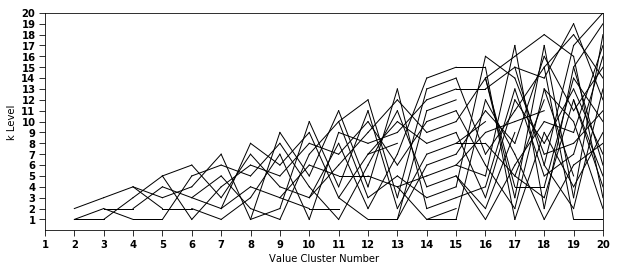

In [32]:

plt.figure(figsize=(10,4))

for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = hp.compute_cluster(all_year_data,years,nclusters1,min_pas=150,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:6]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = hp.compute_cluster(all_year_data,years,nclusters2,min_pas=150,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:6]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        plt.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='black',lw=1.)
     

plt.axis([1,20,0,20])

plt.xticks(np.arange(1,21,1))
plt.yticks(np.arange(1,21,1))
plt.xlabel('Value Cluster Number')
plt.ylabel('k Level')





In [17]:
# make many clusterings

nclusters = np.arange(2,25,1)

year_df_arr = {}
df_arr = {}
stereotype_df_arr = {}
hitter_cluster_centroid_df_arr = {}
StarterCenters = {}
StereotypeKeys = {}



for nclu in nclusters:
    print(nclu)
    year_df,df,stereotype_df,hitter_cluster_centroid_df,transform = hp.compute_cluster(all_year_data,years,nclu,min_pas=150,verbose=0)

    year_df_arr[nclu] = year_df
    df_arr[nclu] = df
    stereotype_df_arr[nclu] = stereotype_df
    hitter_cluster_centroid_df_arr[nclu] = hitter_cluster_centroid_df
    StarterCenters[nclu] = np.array(hitter_cluster_centroid_df)[:,0:6]
    StereotypeKeys[nclu] = {}
    
    
    for ii in range(len(stereotype_df['Value Cluster'])):
        StereotypeKeys[nclu][ii] = stereotype_df['Value Cluster'][ii]



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [15]:
Y.shape

(1587, 6)

[1.66538801 3.42342477 3.21841404 1.63624003 3.28625911 2.49352178]
*************   2 ***************
*************   3 ***************
*************   4 ***************
*************   5 ***************
*************   6 ***************
*************   7 ***************
*************   8 ***************
*************   9 ***************
*************   10 ***************
*************   11 ***************
*************   12 ***************
*************   13 ***************
*************   14 ***************
*************   15 ***************
*************   16 ***************
*************   17 ***************
*************   18 ***************
*************   19 ***************
*************   20 ***************
*************   21 ***************
*************   22 ***************
*************   23 ***************


Text(0, 0.5, 'k Level')

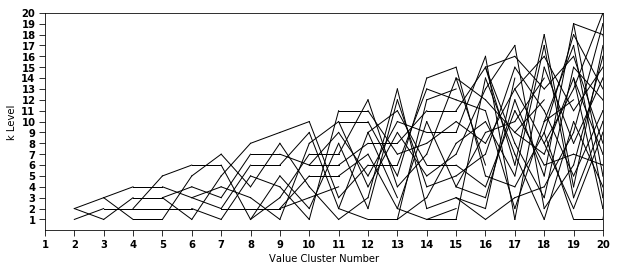

In [29]:

# using the final cluster, compute the standard deviations

Y = df[['HR.Normalize','H.Normalize',\
        'AB.Normalize','SB.Normalize', 'RBI.Normalize', 'R.Normalize']].values

STDEVS = np.array([np.std(Y[:,0]),np.std(Y[:,1]),np.std(Y[:,2]),np.std(Y[:,3]),np.std(Y[:,4]),np.std(Y[:,5])])

print(STDEVS)

STDEVS = np.ones(Y.shape[1])


plt.figure(figsize=(10,4))

StarterCenterMatches = {}

ClusterLinks = {}
ClusterLinksO = {}

for x in nclusters[:-1]: # parent cluster
    print('*************  ',x,'***************')
    ClusterLinks[x] = []
    ClusterLinksO[x] = []
    
    y = x+1
    # find the closest cluster to each cluster
    for c in range(0,StarterCenters[y].shape[0]):
        #print(x,c)
                
        # loop through the previous clusters and find the closest in normalized distance
        diffarr = np.array([np.abs(StarterCenters[x][d]-StarterCenters[y][c])/STDEVS for d in range(StarterCenters[x].shape[0])])

        #print(np.sum(diffarr,axis=1))
        #print(diffarr)
        diffval = np.min(np.sum(diffarr,axis=1),axis=0)
                
        diffind = np.argmin(np.sum(diffarr,axis=1),axis=0)
                
        # make the links: x: 
        ClusterLinks[x].append([[x,StereotypeKeys[x][diffind]],[y,StereotypeKeys[y][c]]])
                
        ClusterLinksO[x].append([[x,diffind],[y,c]])


for x in ClusterLinks.keys():
    for y in range(len(ClusterLinks[x])):
        #plt.plot(np.array(ClusterLinks[x][y])[:,1],np.array(ClusterLinks[x][y])[:,0],color='black',lw=1.)
        plt.plot(np.array(ClusterLinks[x][y])[:,0],np.array(ClusterLinks[x][y])[:,1],color='black',lw=1.)

        
#plt.axis([0,20,20,1])
plt.axis([1,20,0,20])

plt.xticks(np.arange(1,21,1))
plt.yticks(np.arange(1,21,1))
plt.xlabel('Value Cluster Number')
plt.ylabel('k Level')



### Rentz Method

Fit an exponential decline to the total distance metric.

3 1152.4018095031374
4 837.4459437082077
5 655.9302331856379
6 536.3361160356561
7 451.98267412695446
8 390.00729380699636
9 342.34719297407497
10 304.6934134681285
11 274.4813238848372
12 249.7429554626009
13 228.655544980481
14 210.33547503073018
15 195.33479506635356
16 181.59762191155536
17 169.50059700126934
18 159.07246529677568
19 150.38223225265725
20 142.07297316559732
21 134.43377461591157
22 127.74276717254408
23 121.7598873787233
24 116.10456130304262
(array([-4.07361946e+00,  7.63154206e-01,  3.66765680e+08]), array([[-3.37905404e+03,  1.01648510e+00,  3.13178554e+11],
       [-6.76746815e+00,  4.41469745e-01,  4.49528995e+09],
       [ 2.44661229e+11,  3.79446648e+09,  1.13724171e+19]]))
Cluster 3
0.73
Cluster 4
0.78
Cluster 5
0.82
Cluster 6
0.84
Cluster 7
0.86
Cluster 8
0.88
Cluster 9
0.89
Cluster 10
0.9
Cluster 11
0.91
Cluster 12
0.92
Cluster 13
0.92
Cluster 14
0.93
Cluster 15
0.93
Cluster 16
0.93
Cluster 17
0.94
Cluster 18
0.95
Cluster 19
0.94
Cluster 20
0.95
Cluster 2

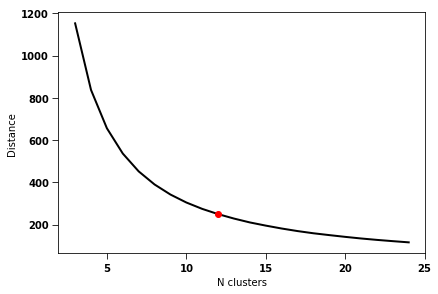

In [5]:

min_clusters = 3
nclusters = np.arange(min_clusters,25,1)#range(2,15)
distances = np.zeros(len(nclusters))

for indx,ccen in enumerate(nclusters):

    year_df,df,stereotype_df,hitter_cluster_centroid_df,transform = hp.compute_cluster(all_year_data,years,ccen,min_pas=150,verbose=0)

    
    for p in transform:
        # why is this the minimum value?
        distances[indx] += np.min(np.sqrt(p))
        #distances[indx] += np.sum(np.sqrt(p))

    distances[indx] /= float(ccen)
    print(ccen,distances[indx])
     
        
# after doing the centering, compute the exponential decline
print(curve_fit(lambda t,a,b,c: a*np.exp(b*t) + c,  ccen,  distances))

# Determine second derivs
second_derivs = []
for i in range(0, len(distances)-1):
    print("Cluster {0}".format(i+3))
    cur_cluster_deriv =  round(distances[i+1]/distances[i], 2)
    print(cur_cluster_deriv)
    second_derivs.append(cur_cluster_deriv)

# Find inflection point
last_deriv = second_derivs[0]
end = 0

for i in second_derivs[1:]:
    if end == 1:
        pass
    else:
        print("Current Deriv: "+ str(i))
        print("Last Deriv: "+ str(last_deriv))
        if i <= last_deriv:
            end = 1
        else:
            last_deriv = i

# Assign Total Clusters        
tot_clusters = min_clusters + second_derivs.index(last_deriv)

# Plot out the results
plt.figure()
plt.plot(nclusters,distances,color='black')
plt.plot(nclusters[second_derivs.index(last_deriv)],distances[second_derivs.index(last_deriv)], marker='o', color='r')
plt.tight_layout()
plt.xlabel('N clusters')
plt.ylabel('Distance')
plt.savefig('cluster_number.png',dpi=300)


In [6]:
print(nclusters[second_derivs.index(last_deriv)])

12


In [7]:
transform.shape

(1587, 24)